In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means


random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Using TensorFlow backend.


In [2]:


tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')



In [4]:
data = pd.read_json("../data/train.json", orient='records')
data.head()
train_df = data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


In [5]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


In [6]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

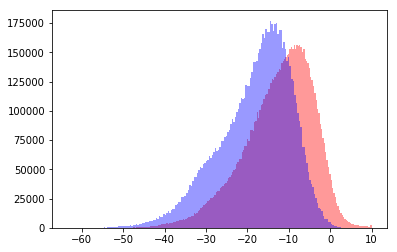

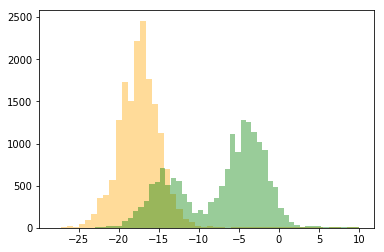

In [7]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

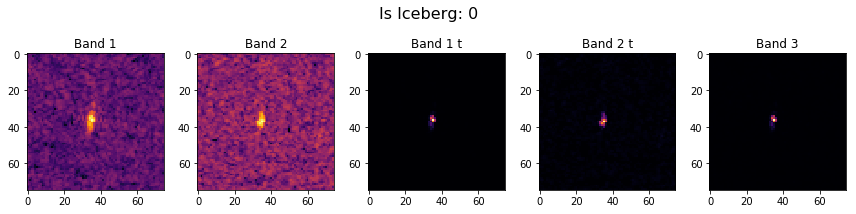

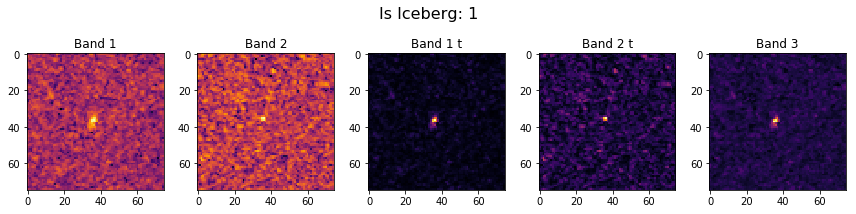

In [10]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")

In [11]:


y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index


y_angle.head()




,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.3, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1122, 75, 75, 4)
(482, 75, 75, 4)


In [13]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        return [temp_stacked1, temp_stacked2, 
                nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

(1122, 75, 75, 4)


In [14]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [15]:


def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)



In [16]:


#custom generator for denoising
from collections import Generator
class Datagen_denoising(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3]),axis=3)
        return temp_stacked, temp_stacked
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
        
datagen_denoising = Datagen_denoising(imagegen=datagen)
datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)



In [17]:


m_input = Input(shape=(75,75,4), name='m_input')

#conv layers for main_input
x1 = BatchNormalization()(m_input)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')

model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])



In [18]:
#model training
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
                    steps_per_epoch=len(X)/8,
                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
                    validation_steps=len(X)/8,
                    #validation_data=[X_val,y_val],
                    epochs=10)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/10
201/200 [==============================] - 24s - loss: 18.6186 - mean_absolute_error: 2.4224 - val_loss: 12.8776 - val_mean_absolute_error: 2.1782
Epoch 2/10
201/200 [==============================] - 22s - loss: 11.7839 - mean_absolute_error: 1.9155 - val_loss: 16.6396 - val_mean_absolute_error: 2.4675
Epoch 3/10
201/200 [==============================] - 22s - loss: 12.4861 - mean_absolute_error: 1.9374 - val_loss: 13.7208 - val_mean_absolute_error: 1.9810
Epoch 4/10
201/200 [==============================] - 23s - loss: 11.5363 - mean_absolute_error: 1.9113 - val_loss: 3.7442 - val_mean_absolute_error: 1.2026
Epoch 5/10
201/200 [==============================] - 22s - loss: 9.2202 - mean_absolute_error: 1.7319 - val_loss: 5.9495 - val_mean_absolute_error: 1.4909
Epoch 6/10
201/200 [==============================] - 22s - loss: 9.2116 - mean_absolute_error: 1.7237 - val_loss: 4.0751 - val_mean_absolute_error: 1.1839
Epoch 7/10
201/200 [==============================] - 23s

In [19]:


X_nn_denoised = model_denoise.predict(X, verbose=1)



1600/1604 [============================>.] - ETA: 0s

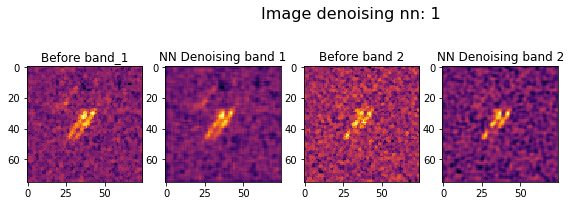

In [20]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before band_1")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("NN Denoising band 1")
ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
ax3 = fig.add_subplot(253)
ax3.set_title("Before band 2")
ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax4 = fig.add_subplot(254)
ax4.set_title("NN Denoising band 2")
ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

In [21]:
model_code="CNN_2017_12_21_v21"
model_comment="2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0"

In [22]:
%%writefile current_model.py

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
x3 = model_denoise(aux_input_nn)
x3 = InputBlock(x3,dropout=0.2, prefix='a_input_nn')

x = Concatenate(axis=3)([x1,x2,x3])
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
#x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])

#dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        aux_input_nn, 
                        angle_input], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Writing current_model.py


In [23]:
%run -i current_model.py

In [24]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def step_decay2(epoch):
    initial_lrate = 0.000001
    drop = 0.66
    patience = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001):
        self.initial_lrate=initial_lrate

    def step_decay(epoch,logs):
        initial_lrate = self.initial_lrate
        drop = 0.66
        patience = 5.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

def get_callbacks(filepath, patience=10, step_decay=step_decay):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

In [25]:
model_f.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
aux_input_nn (InputLayer)        (None, 75, 75, 4)     0                                            
____________________________________________________________________________________________________
main_input (InputLayer)          (None, 75, 75, 2)     0                                            
____________________________________________________________________________________________________
aux_input (InputLayer)           (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
Model_nn_denoising (Model)       (None, 75, 75, 4)     1252        aux_input_nn[0][0]               
___________________________________________________________________________________________

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [27]:


#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay)



In [29]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=24, shuffle=False), 
                    validation_steps=len(X_val)/12,
                    #validation_data=[X_val,y_val],
                    epochs=56, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/56
47/46 [==============================] - 96s - loss: 0.5625 - acc: 0.7272 - val_loss: 0.6162 - val_acc: 0.6497
Epoch 2/56
47/46 [==============================] - 94s - loss: 0.4734 - acc: 0.7663 - val_loss: 0.4407 - val_acc: 0.8191
Epoch 3/56
47/46 [==============================] - 90s - loss: 0.4585 - acc: 0.7982 - val_loss: 0.5121 - val_acc: 0.7489
Epoch 4/56
47/46 [==============================] - 92s - loss: 0.4443 - acc: 0.8058 - val_loss: 0.4464 - val_acc: 0.7819
Epoch 5/56
47/46 [==============================] - 92s - loss: 0.4356 - acc: 0.8056 - val_loss: 0.5586 - val_acc: 0.6989
Epoch 6/56
47/46 [==============================] - 91s - loss: 0.4072 - acc: 0.8141 - val_loss: 0.3717 - val_acc: 0.8426
Epoch 7/56
47/46 [==============================] - 90s - loss: 0.3665 - acc: 0.8443 - val_loss: 0.4264 - val_acc: 0.7872
Setting learning rate:  0.00066
Epoch 8/56
47/46 [==============================] - 89s - loss: 0.3572 - acc: 0.8372

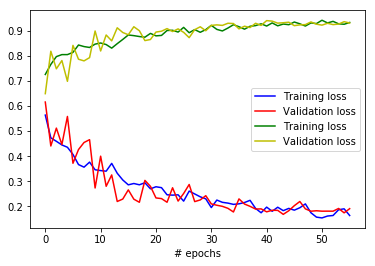

In [30]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.plot(H.history['acc'], color="g", label='Training loss')
plt.plot(H.history['val_acc'], color="y", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [31]:
#addtional training epochs
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay2)
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(X_val)/12,
                    #validation_data=[X_val,y_val],
                    epochs=14, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  1e-06
Epoch 1/14
47/46 [==============================] - 99s - loss: 0.1529 - acc: 0.9359 - val_loss: 0.1894 - val_acc: 0.9321
Epoch 2/14
47/46 [==============================] - 97s - loss: 0.1789 - acc: 0.9350 - val_loss: 0.1817 - val_acc: 0.9361
Epoch 3/14
47/46 [==============================] - 98s - loss: 0.1571 - acc: 0.9403 - val_loss: 0.1879 - val_acc: 0.9313
Epoch 4/14
47/46 [==============================] - 100s - loss: 0.1822 - acc: 0.9255 - val_loss: 0.1910 - val_acc: 0.9304
Epoch 5/14
47/46 [==============================] - 99s - loss: 0.1509 - acc: 0.9486 - val_loss: 0.1900 - val_acc: 0.9296
Setting learning rate:  6.6e-07
Epoch 6/14
47/46 [==============================] - 99s - loss: 0.1545 - acc: 0.9388 - val_loss: 0.1821 - val_acc: 0.9329
Epoch 7/14
47/46 [==============================] - 100s - loss: 0.1444 - acc: 0.9362 - val_loss: 0.1778 - val_acc: 0.9337
Epoch 8/14
47/46 [==============================] - 100s - loss: 0.1605 - acc: 0.9

In [32]:
for key in H.history:
    H.history[key].extend(H2.history[key])

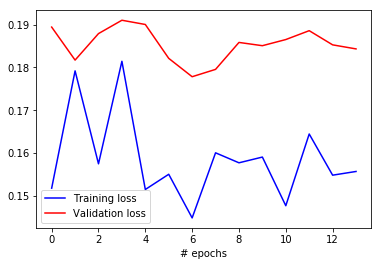

In [33]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

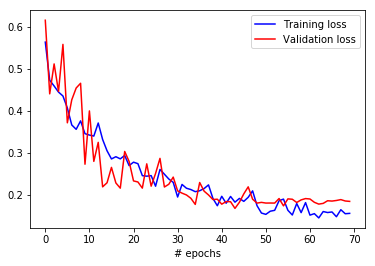

In [34]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [35]:
model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
model_f.save(model_object_path)
#model_f = load_model(model_object_path)

In [36]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
with open('current_model.py','r') as model_python_code_file:
    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
                                    "val_loss [min]":[H.history['val_loss'][argmin]],
                                    "epoch [val_loss [min]]":argmin,
                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
                                    
                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
                                    "epoch [val_acc [max]]":argmax_acc,
                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
                                    
                                    "model_path":[model_object_path],
                                    "model_weights_path":[model_best_weights_path],
                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
                                    "model_comment":[model_comment]
                                })
                               
models_history = models_history[["timestamp", 
                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
                                 "model_path","model_weights_path","model_python_code","model_comment"]]
models_history.head()

,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
0,2017_12_22_11_10_09,43,0.167591,0.182417,0.932979,0.927807,40,0.941489,0.196465,0.177671,0.919786,C:\github\statoil-iceberg-classifier-challenge...,C:\github\statoil-iceberg-classifier-challenge...,"\ndef InputBlock(x, dropout=0.2, prefix=''):\n...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."


In [37]:
print("Min validation loss epoch:")
print("epoch: %d" %(argmin),
      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
     )
print("Max validation accuracy epoch:")
print("epoch: %d" %(argmax_acc),
      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
     )
print("model comment:", model_comment)

Min validation loss epoch:
epoch: 43 ; val loss [min] 0.1676:  ; training loss: 0.1824 ; val acc: 0.9330 ; training acc: 0.9278 
Max validation accuracy epoch:
epoch: 40 ; val loss 0.1777:  ; training loss: 0.1965 ; val acc [max]: 0.9415 ; training acc: 0.9198 
model comment: 2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0


In [48]:
with open('models_history.csv', 'a') as f:
    models_history.to_csv(f, header=False,index=False)
    models_history.to_csv(f, index=False)

In [49]:


df = pd.read_csv('models_history.csv')
df.tail()



,2017_12_22_11_10_09,43,0.16759140440758238,0.1824172053904457,0.9329787188387931,0.9278074863122746,40,0.941489361194854,0.196465196974456,0.17767141410645018,0.9197860924317875,C:\github\statoil-iceberg-classifier-challenge\notebooks\models\model.CNN_2017_12_21_v21_2017_12_22_11_10_09.hdf5,C:\github\statoil-iceberg-classifier-challenge\notebooks\models\weights.CNN_2017_12_21_v21_2017_12_22_11_10_09.hdf5,"def InputBlock(x, dropout=0.2, prefix=''): #conv layers for input x = BatchNormalization()(x) x = Conv2D(64, (3,3), activation='relu')(x) x = MaxPooling2D((2, 2), strides=(2, 2))(x) x = BatchNormalization()(x) x = Dropout(dropout)(x) return(x) main_input = Input(shape=(75,75,2), name='main_input') aux_input = Input(shape=(75,75,3), name='aux_input') aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn') x1 = InputBlock(main_input, prefix='m_input') x2 = InputBlock(aux_input, prefix='a_input') x3 = model_denoise(aux_input_nn) x3 = InputBlock(x3,dropout=0.2, prefix='a_input_nn') x = Concatenate(axis=3)([x1,x2,x3]) #x = BatchNormalization()(x) #x = Dropout(0.2)(x) #conv-block x = Conv2D(128, (3, 3), activation='relu')(x) x = MaxPooling2D((2, 2), strides=(2, 2))(x) x = BatchNormalization()(x) x = Dropout(0.2)(x) #conv-block x = Conv2D(256, (3, 3), activation='relu')(x) x = MaxPooling2D((2, 2), strides=(2, 2))(x) x = BatchNormalization()(x) x = Dropout(0.2)(x) #flatten x = Flatten()(x) angle_input = Input(shape=[1], name='angle_input') #x1 = BatchNormalization()(angle_input) merged = Concatenate()([x, angle_input]) #dense-block x = Dense(513, activation='relu')(merged) x = BatchNormalization()(x) x = Dropout(0.2)(x) #dense-block x = Dense(256, activation='relu')(x) x = BatchNormalization()(x) x = Dropout(0.2)(x) main_output = Dense(1, activation='sigmoid', name='main_output')(x) model_f = Model(inputs=[main_input,aux_input, aux_input_nn, angle_input], outputs=[main_output]) model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0), loss='binary_crossentropy', metrics=['accuracy'])","2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0"
0,2017_12_22_11_10_09,43,0.16759140440758238,0.1824172053904457,0.9329787188387931,0.9278074863122746,40,0.941489361194854,0.196465196974456,0.17767141410645018,0.9197860924317875,C:\github\statoil-iceberg-classifier-challenge...,C:\github\statoil-iceberg-classifier-challenge...,"\r\ndef InputBlock(x, dropout=0.2, prefix=''):...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."
1,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
2,2017_12_22_11_10_09,43,0.16759140440758238,0.1824172053904457,0.9329787188387931,0.9278074863122746,40,0.941489361194854,0.196465196974456,0.17767141410645018,0.9197860924317875,C:\github\statoil-iceberg-classifier-challenge...,C:\github\statoil-iceberg-classifier-challenge...,"\r\ndef InputBlock(x, dropout=0.2, prefix=''):...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."


In [50]:
model_f.load_weights(model_best_weights_path)

In [51]:
model_f.evaluate(X_val,y_val, verbose=1, batch_size=64)

ValueError: The model expects 4 input arrays, but only received one array. Found: array with shape (482, 75, 75, 4)

In [42]:


test_df = pd.read_json("../data/test.json")



In [43]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [44]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)

In [53]:
predictions = model_f.predict(X_test,verbose=1, batch_size=64)

ValueError: The model expects 4  arrays, but only received one array. Found: array with shape (8424, 75, 75, 4)

In [46]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions.reshape(-1)})
submission.head()

NameError: name 'predictions' is not defined

In [ ]:
submission.to_csv("../submission/submission31.csv", index=False)